# 2.5 Single Pair Per Symbol

New training approach:
1. **One pair per symbol per day** - shuffle symbols, pair consecutively (0-1, 2-3, 4-5...)
2. **High dropout for fundamentals** - combat 60x overexposure from quarterly updates
3. **Medium dropout for price features**

This ensures each symbol appears exactly once per day, forcing diverse comparisons.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from scipy.stats import spearmanr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
    # Feature dimensions
    n_fundamental_features: int = 19
    n_price_features: int = 9
    n_embedding_dim: int = 768
    
    # Encoder latent dimensions
    fundamental_latent: int = 32
    price_latent: int = 16
    news_latent: int = 32
    
    # Dropout - tunable per encoder
    fundamental_dropout: float = 0.5  # HIGH - combat 60x overexposure
    price_dropout: float = 0.6        # MEDIUM
    news_dropout: float = 0.2         # Standard
    
    # News influence cap
    news_alpha: float = 0.8
    
    # Training
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 1e-3
    n_epochs: int = 25

## 1. Load Data

In [4]:
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])

print(f"Dataset: {len(df):,} rows")
print(f"Date range: {df['feature_date'].min().date()} to {df['feature_date'].max().date()}")
print(f"Symbols: {df['symbol'].nunique():,}")

Dataset: 2,092,929 rows
Date range: 2021-01-13 to 2025-12-18
Symbols: 3,506


In [5]:
# Feature columns
price_feat_cols = [
    "overnight_gap_z", "intraday_ret_z",
    "ret_1d_z", "ret_2d_z", "ret_3d_z", "ret_5d_z",
    "vol_5d_z", "dist_from_high_5d_z", "dist_from_low_5d_z"
]
fund_feat_cols = [c for c in df.columns if c.endswith("_z") and c not in price_feat_cols and c != "news_count_z"]
emb_cols = [c for c in df.columns if c.startswith("emb_")]

print(f"Price features: {len(price_feat_cols)}")
print(f"Fundamental features: {len(fund_feat_cols)}")
print(f"Embedding dims: {len(emb_cols)}")

Price features: 9
Fundamental features: 19
Embedding dims: 768


In [6]:
# Time-based split
dates = sorted(df["feature_date"].unique())
n_dates = len(dates)
train_end_idx = int(n_dates * 0.7)
val_end_idx = int(n_dates * 0.8)

train_dates = set(dates[:train_end_idx])
val_dates = set(dates[train_end_idx:val_end_idx])
test_dates = set(dates[val_end_idx:])

train_df = df[df["feature_date"].isin(train_dates)].copy()
val_df = df[df["feature_date"].isin(val_dates)].copy()
test_df = df[df["feature_date"].isin(test_dates)].copy()

print(f"Train: {len(train_df):,} rows, {len(train_dates)} days")
print(f"Val: {len(val_df):,} rows, {len(val_dates)} days")
print(f"Test: {len(test_df):,} rows, {len(test_dates)} days")

Train: 1,418,494 rows, 830 days
Val: 210,247 rows, 118 days
Test: 464,188 rows, 238 days


## 2. Single-Pair Dataset

Each symbol appears in exactly one pair per day:
- Shuffle symbols for each day
- Pair consecutively: (0,1), (2,3), (4,5), ...
- If odd number, last symbol is dropped

In [7]:
class SinglePairDataset(Dataset):
    """Dataset where each symbol appears in exactly one pair per day.
    
    Shuffle symbols each day, pair consecutively: (0,1), (2,3), (4,5)...
    This ensures no symbol dominates training through repeated exposure.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        price_cols: list[str],
        fund_cols: list[str],
        emb_cols: list[str],
    ):
        # Filter to rows with news only
        has_news = (df[emb_cols].abs().sum(axis=1) > 0)
        df_news = df[has_news].copy().reset_index(drop=True)
        print(f"Filtered to news-only: {len(df_news):,} / {len(df):,} rows ({len(df_news)/len(df)*100:.1f}%)")

        self.df = df_news
        self.price_cols = price_cols
        self.fund_cols = fund_cols
        self.emb_cols = emb_cols

        # Group indices by date - use reset df so indices match arrays
        self.date_groups = {}
        for date, group in self.df.groupby("feature_date"):
            indices = group.index.tolist()
            if len(indices) < 2:
                continue
            self.date_groups[date] = indices

        self.dates = list(self.date_groups.keys())
        print(f"Days with sufficient news coverage: {len(self.dates)}")

        # Precompute arrays (indices now 0 to len-1)
        self.price_arr = self.df[price_cols].values.astype(np.float32)
        self.fund_arr = self.df[fund_cols].values.astype(np.float32)
        self.emb_arr = self.df[emb_cols].values.astype(np.float32)
        self.target_arr = self.df["target_return"].values.astype(np.float32)

        # Generate initial pairs
        self.pairs = []
        self._generate_pairs()

    def _generate_pairs(self):
        """Generate pairs: shuffle each day, pair consecutively."""
        pairs = []
        
        for date in self.dates:
            indices = list(self.date_groups[date])  # copy
            np.random.shuffle(indices)
            
            # Pair consecutively: (0,1), (2,3), (4,5)...
            for i in range(0, len(indices) - 1, 2):
                pairs.append((indices[i], indices[i + 1]))
        
        self.pairs = pairs
        
        # Stats
        avg_pairs_per_day = len(pairs) / len(self.dates)
        print(f"Generated {len(self.pairs):,} pairs ({avg_pairs_per_day:.0f} per day avg)")

    def resample_pairs(self):
        """Regenerate pairs with new shuffle."""
        self._generate_pairs()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]

        price_i = self.price_arr[i]
        price_j = self.price_arr[j]
        fund_i = self.fund_arr[i]
        fund_j = self.fund_arr[j]
        emb_i = self.emb_arr[i]
        emb_j = self.emb_arr[j]

        actual_label = 1.0 if self.target_arr[i] > self.target_arr[j] else 0.0

        # Random swap for label balance
        if np.random.random() < 0.5:
            price_i, price_j = price_j, price_i
            fund_i, fund_j = fund_j, fund_i
            emb_i, emb_j = emb_j, emb_i
            label = 1.0 - actual_label
        else:
            label = actual_label

        return {
            "price_i": torch.tensor(price_i),
            "price_j": torch.tensor(price_j),
            "fund_i": torch.tensor(fund_i),
            "fund_j": torch.tensor(fund_j),
            "emb_i": torch.tensor(emb_i),
            "emb_j": torch.tensor(emb_j),
            "label": torch.tensor(label),
        }

In [8]:
# Compare pair counts
print("Pair count comparison:")
print("="*50)

# All pairs (from 2.2)
has_news = (train_df[emb_cols].abs().sum(axis=1) > 0)
train_news = train_df[has_news]
all_pairs = sum(len(g) * (len(g) - 1) // 2 for _, g in train_news.groupby('feature_date'))
print(f"All pairs (2.2 baseline): {all_pairs:,}")

# Single pair per symbol
single_pairs = sum(len(g) // 2 for _, g in train_news.groupby('feature_date'))
print(f"Single pair/symbol (2.5): {single_pairs:,}")
print(f"Reduction: {(1 - single_pairs/all_pairs)*100:.1f}%")

Pair count comparison:
All pairs (2.2 baseline): 71,008,149
Single pair/symbol (2.5): 169,737
Reduction: 99.8%


## 3. Model Architecture

In [9]:
class MultiBranchRanker(nn.Module):
    """Multi-branch model with high fundamental dropout."""
    
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        
        # High dropout for fundamentals
        self.fund_encoder = nn.Sequential(
            nn.Linear(config.n_fundamental_features, 64),
            nn.ReLU(),
            nn.Dropout(config.fundamental_dropout),
            nn.Linear(64, config.fundamental_latent),
            nn.ReLU(),
        )
        
        # Medium dropout for price
        self.price_encoder = nn.Sequential(
            nn.Linear(config.n_price_features, 32),
            nn.ReLU(),
            nn.Dropout(config.price_dropout),
            nn.Linear(32, config.price_latent),
            nn.ReLU(),
        )
        
        # Standard dropout for news
        self.news_encoder = nn.Sequential(
            nn.Linear(config.n_embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(config.news_dropout),
            nn.Linear(128, config.news_latent),
            nn.ReLU(),
        )
        
        fused_dim = config.fundamental_latent + config.price_latent + config.news_latent
        self.output_head = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, price, fund, emb):
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        h_n_scaled = self.config.news_alpha * h_n
        h = torch.cat([h_f, h_p, h_n_scaled], dim=-1)
        return self.output_head(h).squeeze(-1)
    
    def forward_pair(self, price_i, fund_i, emb_i, price_j, fund_j, emb_j):
        score_i = self.forward(price_i, fund_i, emb_i)
        score_j = self.forward(price_j, fund_j, emb_j)
        return torch.sigmoid(score_i - score_j)

## 4. Training Functions

In [10]:
def pairwise_ranking_loss(pred_prob, label, smoothing=0.1):
    smoothed_label = label * (1 - smoothing) + 0.5 * smoothing
    return F.binary_cross_entropy(pred_prob, smoothed_label)


def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in tqdm(loader, desc="Training", leave=False):
        price_i = batch["price_i"].to(device)
        price_j = batch["price_j"].to(device)
        fund_i = batch["fund_i"].to(device)
        fund_j = batch["fund_j"].to(device)
        emb_i = batch["emb_i"].to(device)
        emb_j = batch["emb_j"].to(device)
        label = batch["label"].to(device)
        
        optimizer.zero_grad()
        pred_prob = model.forward_pair(price_i, fund_i, emb_i, price_j, fund_j, emb_j)
        loss = pairwise_ranking_loss(pred_prob, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(label)
        total_correct += ((pred_prob > 0.5) == (label > 0.5)).sum().item()
        total_samples += len(label)
    
    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in tqdm(loader, desc="Evaluating", leave=False):
        price_i = batch["price_i"].to(device)
        price_j = batch["price_j"].to(device)
        fund_i = batch["fund_i"].to(device)
        fund_j = batch["fund_j"].to(device)
        emb_i = batch["emb_i"].to(device)
        emb_j = batch["emb_j"].to(device)
        label = batch["label"].to(device)
        
        pred_prob = model.forward_pair(price_i, fund_i, emb_i, price_j, fund_j, emb_j)
        loss = pairwise_ranking_loss(pred_prob, label)
        
        total_loss += loss.item() * len(label)
        total_correct += ((pred_prob > 0.5) == (label > 0.5)).sum().item()
        total_samples += len(label)
    
    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def get_scores(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    """Score all rows in dataframe."""
    model.eval()
    
    price_arr = torch.tensor(df[price_cols].values.astype(np.float32))
    fund_arr = torch.tensor(df[fund_cols].values.astype(np.float32))
    emb_arr = torch.tensor(df[emb_cols].values.astype(np.float32))
    
    scores = []
    for i in range(0, len(df), batch_size):
        price = price_arr[i:i+batch_size].to(device)
        fund = fund_arr[i:i+batch_size].to(device)
        emb = emb_arr[i:i+batch_size].to(device)
        score = model(price, fund, emb)
        scores.append(score.cpu().numpy())
    
    return np.concatenate(scores)


def compute_daily_ic(df):
    """Compute Spearman IC per day."""
    ics = []
    for date, group in df.groupby("feature_date"):
        if len(group) < 10:
            continue
        ic, _ = spearmanr(group["score"], group["target_return"])
        if not np.isnan(ic):
            ics.append({"date": date, "ic": ic})
    return pd.DataFrame(ics)


def compute_short_returns(df, k=5, clip_return=0.10):
    """Compute daily short returns for bottom-K with return clipping."""
    returns = []
    for date, group in df.groupby("feature_date"):
        if len(group) < k * 2:
            continue
        bottom = group.nsmallest(k, "score")
        clipped_returns = bottom["target_return"].clip(-clip_return, clip_return)
        short_ret = -clipped_returns.mean()
        returns.append({"date": date, "return": short_ret})
    return pd.DataFrame(returns)

## 5. Train Model

In [11]:
# Configuration
config = ModelConfig(
    n_fundamental_features=len(fund_feat_cols),
    n_price_features=len(price_feat_cols),
    n_embedding_dim=len(emb_cols),
    fundamental_dropout=0.8,  # HIGH
    price_dropout=0.4,        # MEDIUM
    news_dropout=0.2,         # Standard
    n_epochs=25,
)

print(f"Config:")
print(f"  Fundamental dropout: {config.fundamental_dropout}")
print(f"  Price dropout: {config.price_dropout}")
print(f"  News dropout: {config.news_dropout}")

Config:
  Fundamental dropout: 0.8
  Price dropout: 0.4
  News dropout: 0.2


In [12]:
# Create datasets
train_dataset = SinglePairDataset(train_df, price_feat_cols, fund_feat_cols, emb_cols)
val_dataset = SinglePairDataset(val_df, price_feat_cols, fund_feat_cols, emb_cols)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

Filtered to news-only: 339,872 / 1,418,494 rows (24.0%)
Days with sufficient news coverage: 830
Generated 169,737 pairs (205 per day avg)
Filtered to news-only: 58,882 / 210,247 rows (28.0%)
Days with sufficient news coverage: 118
Generated 29,411 pairs (249 per day avg)


In [13]:
# Create model
model = MultiBranchRanker(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.n_epochs)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 109,393


In [14]:
# Train
best_val_acc = 0
history = []

for epoch in range(config.n_epochs):
    # Reshuffle pairs each epoch (new random pairings)
    train_dataset.resample_pairs()
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    scheduler.step()
    
    history.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    print(f"Epoch {epoch+1}/{config.n_epochs}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict().copy()

# Load best model
model.load_state_dict(best_state)
print(f"\nBest val accuracy: {best_val_acc:.4f}")

Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1/25: train_loss=0.6928, train_acc=0.5092, val_loss=0.6925, val_acc=0.5096
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2/25: train_loss=0.6928, train_acc=0.5092, val_loss=0.6925, val_acc=0.5086
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3/25: train_loss=0.6927, train_acc=0.5088, val_loss=0.6925, val_acc=0.5129
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4/25: train_loss=0.6925, train_acc=0.5136, val_loss=0.6925, val_acc=0.5120
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5/25: train_loss=0.6924, train_acc=0.5150, val_loss=0.6924, val_acc=0.5151
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6/25: train_loss=0.6925, train_acc=0.5129, val_loss=0.6924, val_acc=0.5130
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 7/25: train_loss=0.6925, train_acc=0.5120, val_loss=0.6924, val_acc=0.5144
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 8/25: train_loss=0.6924, train_acc=0.5123, val_loss=0.6924, val_acc=0.5131
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 9/25: train_loss=0.6923, train_acc=0.5158, val_loss=0.6923, val_acc=0.5143
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 10/25: train_loss=0.6921, train_acc=0.5176, val_loss=0.6924, val_acc=0.5119
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 11/25: train_loss=0.6923, train_acc=0.5162, val_loss=0.6923, val_acc=0.5108
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 12/25: train_loss=0.6922, train_acc=0.5159, val_loss=0.6924, val_acc=0.5100
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 13/25: train_loss=0.6922, train_acc=0.5147, val_loss=0.6925, val_acc=0.5115
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 14/25: train_loss=0.6921, train_acc=0.5170, val_loss=0.6926, val_acc=0.5113
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 15/25: train_loss=0.6919, train_acc=0.5186, val_loss=0.6925, val_acc=0.5108
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 16/25: train_loss=0.6920, train_acc=0.5192, val_loss=0.6925, val_acc=0.5114
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 17/25: train_loss=0.6919, train_acc=0.5178, val_loss=0.6925, val_acc=0.5121
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 18/25: train_loss=0.6918, train_acc=0.5187, val_loss=0.6925, val_acc=0.5128
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 19/25: train_loss=0.6919, train_acc=0.5193, val_loss=0.6926, val_acc=0.5134
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 20/25: train_loss=0.6917, train_acc=0.5190, val_loss=0.6926, val_acc=0.5133
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 21/25: train_loss=0.6918, train_acc=0.5189, val_loss=0.6926, val_acc=0.5139
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 22/25: train_loss=0.6918, train_acc=0.5194, val_loss=0.6925, val_acc=0.5126
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 23/25: train_loss=0.6918, train_acc=0.5188, val_loss=0.6925, val_acc=0.5129
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 24/25: train_loss=0.6917, train_acc=0.5190, val_loss=0.6925, val_acc=0.5124
Generated 169,737 pairs (205 per day avg)


Training:   0%|          | 0/332 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 25/25: train_loss=0.6918, train_acc=0.5196, val_loss=0.6925, val_acc=0.5123

Best val accuracy: 0.5151


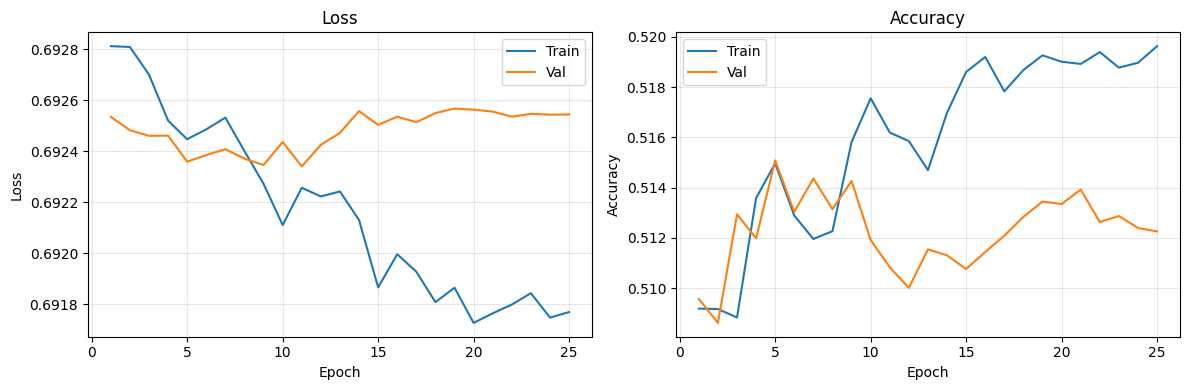

In [17]:
# Plot training curves
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(hist_df['epoch'], hist_df['train_loss'], label='Train')
axes[0].plot(hist_df['epoch'], hist_df['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(hist_df['epoch'], hist_df['train_acc'], label='Train')
axes[1].plot(hist_df['epoch'], hist_df['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Evaluate on Test Set

In [18]:
# Score test set
test_df_eval = test_df.copy()
test_df_eval["score"] = get_scores(model, test_df_eval, price_feat_cols, fund_feat_cols, emb_cols, device)

# Compute metrics
ic_df = compute_daily_ic(test_df_eval)
short_df = compute_short_returns(test_df_eval, k=5, clip_return=0.10)

mean_ic = ic_df['ic'].mean()
ic_sharpe = mean_ic / ic_df['ic'].std() * np.sqrt(252)

short_sharpe = short_df['return'].mean() / short_df['return'].std() * np.sqrt(252)
short_cumret = (1 + short_df['return']).cumprod().iloc[-1] - 1

print("="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Mean IC: {mean_ic:.4f}")
print(f"IC Sharpe: {ic_sharpe:.2f}")
print(f"Short K=5 Sharpe: {short_sharpe:.2f}")
print(f"Short K=5 Return: {short_cumret*100:.1f}%")

TEST SET RESULTS
Mean IC: 0.0272
IC Sharpe: 3.54
Short K=5 Sharpe: 8.10
Short K=5 Return: 6906.4%


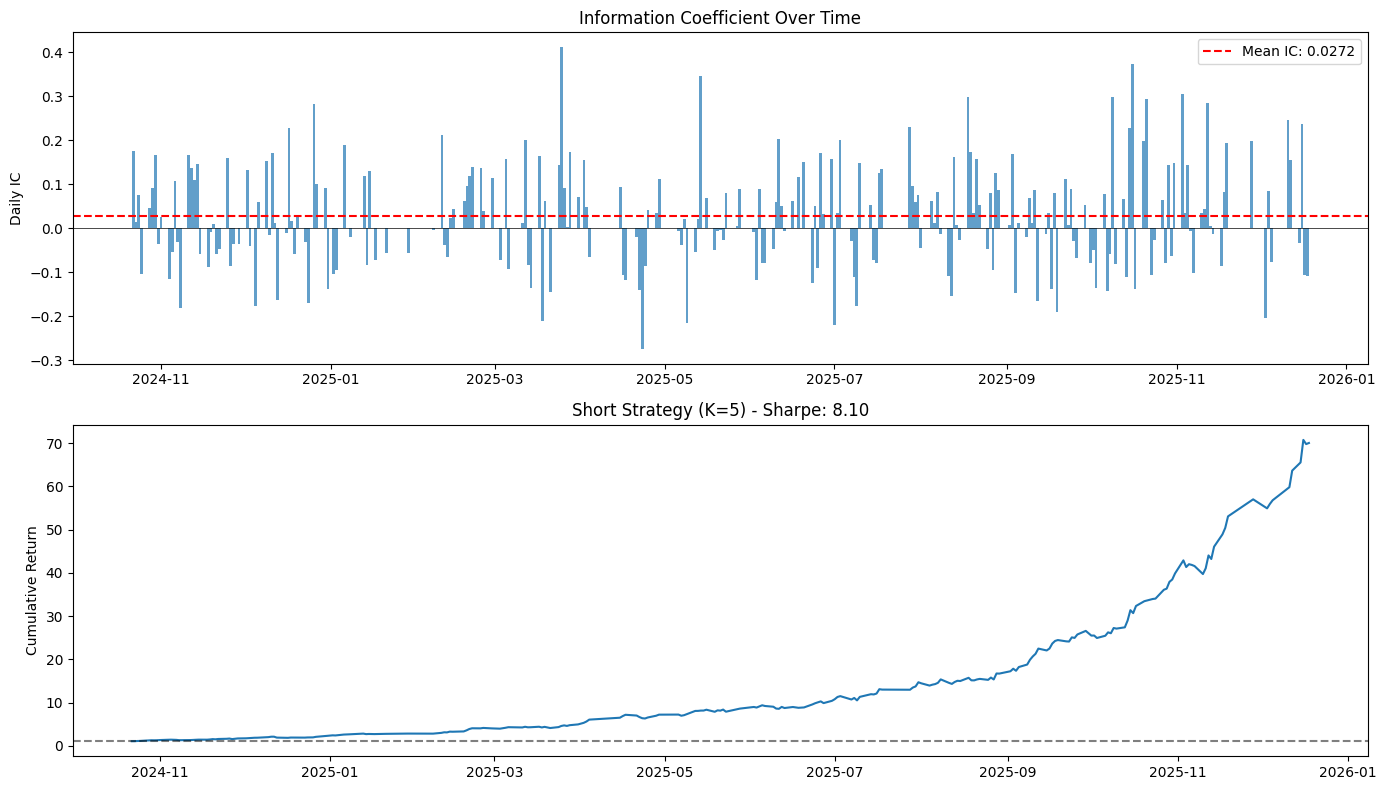

In [19]:
# Plot IC over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Daily IC
ax = axes[0]
ax.bar(ic_df['date'], ic_df['ic'], alpha=0.7, width=1)
ax.axhline(0, color='black', linewidth=0.5)
ax.axhline(mean_ic, color='red', linestyle='--', label=f'Mean IC: {mean_ic:.4f}')
ax.set_ylabel('Daily IC')
ax.set_title('Information Coefficient Over Time')
ax.legend()

# Cumulative short returns
ax = axes[1]
cumret = (1 + short_df['return']).cumprod()
ax.plot(short_df['date'], cumret)
ax.axhline(1, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('Cumulative Return')
ax.set_title(f'Short Strategy (K=5) - Sharpe: {short_sharpe:.2f}')

plt.tight_layout()
plt.show()

## 7. Save Model

In [20]:
torch.save({
    "model_state_dict": model.state_dict(),
    "config": config,
    "price_cols": price_feat_cols,
    "fund_cols": fund_feat_cols,
    "emb_cols": emb_cols,
    "training_approach": "single_pair_per_symbol",
    "results": {
        "mean_ic": mean_ic,
        "ic_sharpe": ic_sharpe,
        "short_sharpe": short_sharpe,
    }
}, "data/model_single_pair_sharpe8.pt")